#Univariate Time Series Analysis

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as tsm
from collections import deque
from scipy.stats  import norm
%matplotlib inline

In [173]:
def lag_graph(lag_array):
    """"Given an array of lags, creates a lag graph."""
    x = np.arange(1, len(lag_array)+1)
    plt.plot(np.linspace(1,len(lag_array)), np.repeat(0, len(np.linspace(1,len(lag_array)))), 
             "-", color="#526774")
    for i in range(len(lag_array)):
        plt.plot(np.repeat(i+1,len(np.linspace(0, lag_array[i]))),
                 np.linspace(0, lag_array[i]), "-", color="#B1A5A5")
    plt.plot(x, lag_array, "o", color="#5A99C4")
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2+2, y1-0.05, y2+0.05))
    plt.title("Autocorrelation Lag {}".format(len(lag_array)))

##Simulating a Theoretical ACF for AR(1) Model

In the code below we are assuming that the population follows the AR(1) model. 

$$y_t = \phi_1y_{t-1} + \delta + \varepsilon_t$$

In [3]:
#Creating a time dependent series

def time_dep_series(mu, initial_val, param, lenght):
    serial = []
    calculated_val = 0 
    for i in range(lenght):
        if i==0:
            calculated_val = mu + param*initial_val 
            serial.append(calculated_val)
        else:
            calculated_val = mu + param*calculated_val
            serial.append(calculated_val)
    return np.array(serial)
    

In [4]:
theoretical_acf = time_dep_series(0, 1, 0.1, 25)

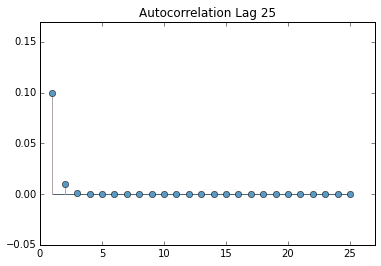

In [5]:
lag_graph(theoretical_acf)

As it is possible to observe in the figure, when we have a AR(1) process the shock that occured in the present has an important effect in the immediate following periods. Note that the periods in the distant future are also affected, by the size gets smaller and smaller at a geometric rate -- beacuse $\phi$ is being raised to higher powers, and as it is a number between -1 and 1 it reduces the magnitude of the effect.

We can also consider adding more lags. See below the theoretical ACF of a process with $\phi_1 = 0.9$ and $\phi_2=-0.7$.

In [6]:
def time_dep_series(mu, initial_val_1, initial_val_2, param_1, param_2, lenght):
    serial = []
    calculated_val = deque([initial_val_1, initial_val_2])
    for i in range(lenght):
            int_val = mu + param_1*calculated_val[0] + param_2*calculated_val[1]
            serial.append(int_val)
            calculated_val.appendleft(int_val)
            calculated_val.pop()
    return np.array(serial)

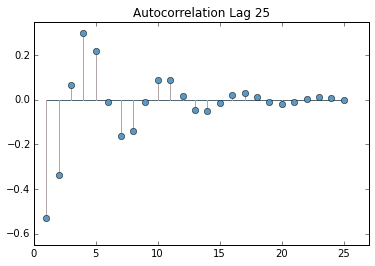

In [7]:
theoretical_acf_2 = time_dep_series(0, -0.2, 0.5, 0.9, -0.7, 25)
lag_graph(theoretical_acf_2)

## Calculating the sample autocorrelation function (ACF):

In [8]:
#Creating a function to calculate lags:
def lag_cal(time_srs, tot_lag):
    lag_cal = []
    for num_lag in range(1, tot_lag+1):
        lag_cal.append(time_srs.autocorr(lag=num_lag))
    return np.array(lag_cal)

## Creating sample data that comes from different processes

As I understand it, the gist of time series is to learn about the past to determine what will happen in the future. The method with which this is perform is important. To accomplish this task we have to go through the painstaking process of determining according to which stochastic process this series behaves. In most of the cases, this is easier said than done! 

Let's start with the baseline case of simple white noise. This model simply states that the past has no effect on the future:

$$Y_t = \varepsilon_t$$

Theoretically, then, this is how a white noise process should look like for a disturbance standard normally distributed and $\mathbb{E}[Y_t]=0$.

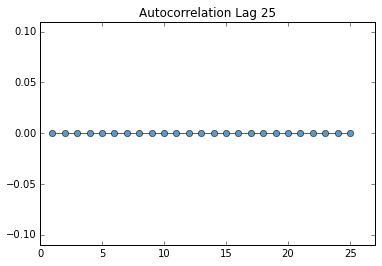

In [23]:
white_noise = np.repeat(0,25)
lag_graph(white_noise)

However, we don't observe in reality a process as clean as that. In reality, we observe different realization of the distribution from which this process is generated. Therefore, once we obtain our data our plot is more likely to look like this. 

Here I use the stats `library` to sample from this theoretical process.

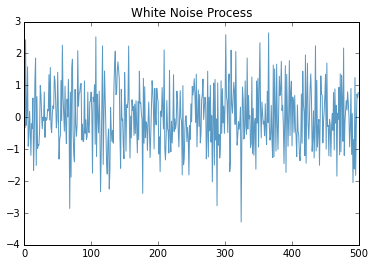

In [155]:
np.random.seed(5)
obs_white_noise = tsm.arima_process.arma_generate_sample(np.array([1]), np.array([1]), 500)
plt.plot(obs_white_noise, color="#5A99C4")
plt.title("White Noise Process")

Even thought this sample comes from a white noise process, it has a lot of variability. If this is the only piece of information that we had and tried to inferred what could be the underlying stochastic process, one might be tempted to see at a process with lag 2, given that there is a high spike for the second lag. Is there a way to be sure. Although we can never be completely positive. There are a series of test developed to determine the type of process we have at hand. 

One of the simplest ones is to rely on distributional assumptions. As we said, a white noise process from which we have obtained a sample is characterized by its disturbance that is normally distributed. We can use this fact to construct confidence intervals.

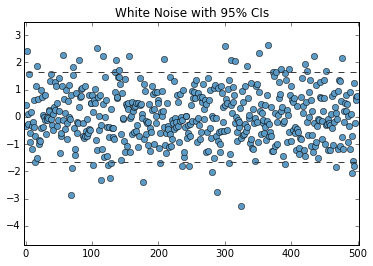

In [174]:
plt.plot(obs_white_noise, "o", color="#5A99C4")
low_ci = norm.ppf(0.05, loc=0, scale=1)
up_ci = norm.ppf(0.95, loc=0, scale=1)
plt.plot(np.linspace(1, len(obs_white_noise)),
         np.repeat(low_ci, len(np.linspace(1, len(obs_white_noise)))),'--', color="#3B3C3F")
plt.plot(np.linspace(1, len(obs_white_noise)), 
         np.repeat(up_ci, len(np.linspace(1, len(obs_white_noise)))),'--', color="#3B3C3F")
x1, x2, y1, y2 = plt.axis()
plt.axis((x1-2, x2+2, y1-0.7, y2+0.5))
plt.title("White Noise with 95% CIs")

In the plot is easy to observe that most of our lag fall within the confidence intervals. This should be no surprise. As well, it should be no surprise that there are some cases where the lags fall outside the confidence intervals. Per definition, this intervals are suppose to capture 95% of the distribution values. Therefore, is not surprising that there are some extreme realizations that fall outside its boundaries. 

We can also calculate de **Autocorrelation Function** of this process. The ACF help us determine what kind of process we have at hand, which is the key for model selection.


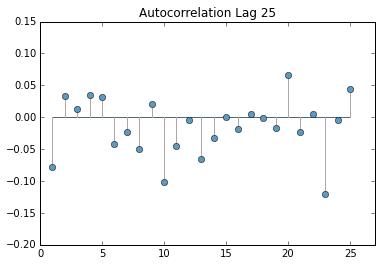

In [175]:
df_obs_white_noise = pd.DataFrame(obs_white_noise, columns=["values"])
lags_white = lag_cal(df_obs_white_noise["values"], 25)
lag_graph(lags_white)

We can also test for the significance of the lags. For this, we make use of the facts that if a time series has been generated by a white noise process, then the sample of autocorrelation coefficients is distributed $N(0, 1/ \sqrt{T}))$.

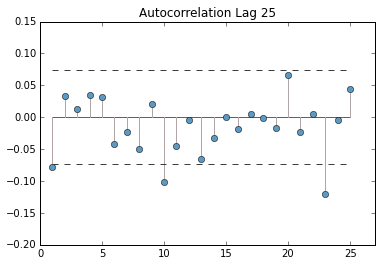

In [176]:
#Calculating CIs for the ACF coefficients
low_ci = norm.ppf(0.05, loc=0, scale=1/np.sqrt(500))
up_ci = norm.ppf(0.95, loc=0, scale=1/np.sqrt(500))
lag_graph(lags_white)
plt.plot(np.linspace(1, len(lags_white)), 
         np.repeat(low_ci, len(np.linspace(1, len(lags_white)))),'--', color="#3B3C3F")
plt.plot(np.linspace(1, len(lags_white)), 
         np.repeat(up_ci, len(np.linspace(1, len(lags_white)))),'--', color="#3B3C3F")

Note that in this case we have started the other way around. In real life you only get a sample of the data, and the difficult part is determining which stochastic process could it be related to. With the above graph, could you conclude that it comes from a white noise process? It is not easy, becuase we might be tempted to conclude that there is some type of correlation, at least with the immediate preceeding time, as with an MA(1) process that we explore below.

##Example of a MA(1) process

Let's see what happens with the Moving average with a lag 1. We will do the same exercise as with the white noise, generating a random sample from this population model:

$$y_t = 2 + \varepsilon_t + 0.8\varepsilon_{t-1}$$

In [211]:
obs_ma_1 = tsm.arima_process.arma_generate_sample(np.array([1]), np.array([1, 0.8]), 200)

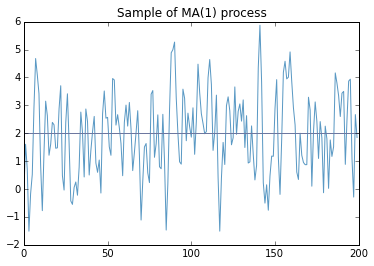

In [212]:
plt.plot(obs_ma_1+2, "-", color="#5A99C4")
plt.axhline(2, color="#6D78A0")
plt.title("Sample of MA(1) process")

For this process is also possible to compute the autocorrelation function, in order to determine if what we see corresponds to this particular stochastic process.

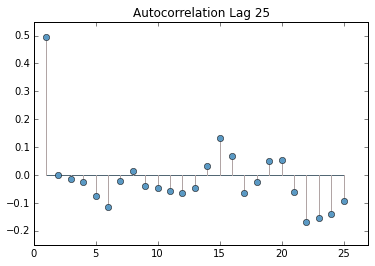

In [213]:
df_obs_ma_1 = pd.DataFrame(obs_ma_1, columns=["values"])
lags_obs_ma_1 = lag_cal(df_obs_ma_1["values"], 25)
lag_graph(lags_obs_ma_1)

As perfomed before, we can also ask for the significance of this correlation coefficients. 

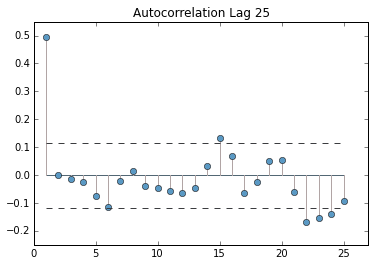

In [214]:
low_ci = norm.ppf(0.05, loc=0, scale=1/np.sqrt(200))
up_ci = norm.ppf(0.95, loc=0, scale=1/np.sqrt(200))
lag_graph(lags_obs_ma_1)
plt.plot(np.linspace(1, len(lags_obs_ma_1)), 
         np.repeat(low_ci, len(np.linspace(1, len(lags_obs_ma_1)))),'--', color="#3B3C3F")
plt.plot(np.linspace(1, len(lags_obs_ma_1)), 
         np.repeat(up_ci, len(np.linspace(1, len(lags_obs_ma_1)))),'--', color="#3B3C3F")

As the graph clearly shows, we have one spike just afterwards that is clearly significance. The rest falls within the confidence intervals. Of course, MA(1) is not the only stochastic process available. The past may be more persistent that considering just the last period. That is why multiple lags can factor in the future.


$$\rho_k = \begin{cases} \frac{-\theta_k +\theta_1\theta_{k+1} +...+ \theta_{q-k}\theta_q}{1 + \theta_1^2 + \theta_2^2 + ... + \theta_q^2} &\mbox{if } k = 1,...,q \\ 
0 & \mbox{if } k > q \end{cases}$$

<IPython.core.display.Math object>

In [222]:
plt.plot(us_savings["PSAVERT"], us_savings["PSAVERT"].shift(1), ".")

NameError: name 'us_savings' is not defined

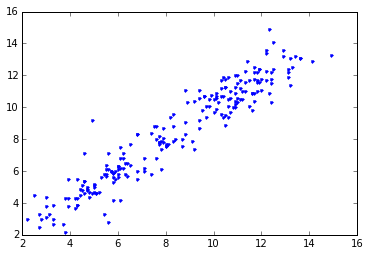

In [214]:
plt.plot(us_savings["PSAVERT"], us_savings["PSAVERT"].shift(2), ".")

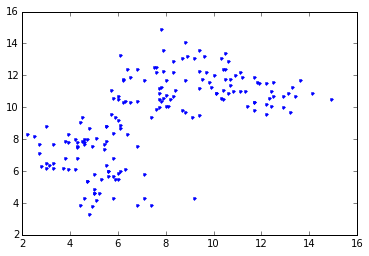

In [225]:
plt.plot(us_savings["PSAVERT"], us_savings["PSAVERT"].shift(50), ".")

In [366]:
dq = deque([1, 2])

In [367]:
dq.appendleft('e')

In [368]:
dq

deque(['e', 1, 2])

In [369]:
dq.pop()

2

In [370]:
dq

deque(['e', 1])

In [36]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

In [187]:
tsm.arima_process.arma_generate_sample?